In [1]:
# run the script initnotebook.py in the cuurent folder
# Error when run multiple times becasue the directory changed
%run initnotebook.py

current working dir/home/abjawad/Documents/GitHub/local-attention-model


In [2]:
import torch
from  torch.utils.data import DataLoader
import torch.nn as nn
from models.builder import EncoderDecoder as segmodel
from dataloader.cfg_defaults import get_cfg_defaults
from config_cityscapes import *
import os
from dataloader.cityscapes_dataloader import CityscapesDataset
from val_segformer_rgbonly import val_cityscape

In [3]:
from visualizer.visualizer import *

In [4]:
output_dir = '/home/abjawad/Documents/GitHub/local-attention-model/visualizer/images'
if os.path.exists(output_dir):
    print('Output directory exists')

Output directory exists


In [5]:
# # # create a random image tensor of torch.Size([1, 64, 256, 256]) and save it
# img = torch.rand(1, 64, 256, 256)

# save_after_block(img, 'average', output_dir)

In [6]:
config_path = 'dataloader/cityscapes_rgbd_config.yaml'
config_path = os.path.join(projectFolder, config_path)

cfg = get_cfg_defaults()
cfg.merge_from_file(config_path)
cfg.freeze()

data_mean = [0.291,  0.329,  0.291]
data_std = [0.190,  0.190,  0.185]

In [7]:
cityscapes_test = CityscapesDataset(cfg, split='val')
test_loader = DataLoader(cityscapes_test, batch_size=1, shuffle=False, num_workers=4) # batchsize?
print(f'total test sample: {len(cityscapes_test)} v_iteration:{len(test_loader)}')


Using RGB input
Using RGB input
Found 500 val images
total test sample: 500 v_iteration:500


In [8]:
pretrained_model_path = './pretrained/model_400.pth'
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=config.background)

model = segmodel(cfg=config, criterion=criterion, norm_layer=nn.BatchNorm2d, test=True)
model = nn.DataParallel(model, device_ids = config.device_ids)
# model.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

23 18:01:20 Using backbone: Segformer-B2
23 18:01:21 Using MLP Decoder


In [9]:
saved_model_path = os.path.join(projectFolder, pretrained_model_path)
print(saved_model_path)
# exit()
state_dict = torch.load(saved_model_path)
model.load_state_dict(state_dict['model'], strict=False)
print(f'model loaded')
epoch = state_dict['epoch']


/home/abjawad/Documents/GitHub/local-attention-model/./pretrained/model_400.pth
model loaded


In [10]:
# val_loss, val_mean_iou = val_cityscape(epoch, test_loader, model)

input:  torch.Size([1, 3, 1024, 1024])
Input Image saved at /home/abjawad/Documents/GitHub/local-attention-model/visualizer/images/input.png
x before proj:  torch.Size([1, 3, 1024, 1024])
x after proj:  torch.Size([1, 64, 256, 256])
x after flatten:  torch.Size([1, 65536, 64])
############### Stage 1 ##########################
tokenization:  torch.Size([1, 65536, 64])


23 18:01:25 WRN Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image saved at /home/abjawad/Documents/GitHub/local-attention-model/visualizer/images/stage1.png
output:  torch.Size([1, 64, 256, 256])
Output Image saved at /home/abjawad/Documents/GitHub/local-attention-model/visualizer/images/Bstage1.png
******** End Stage 1 **************
############### Stage 2 ##########################
x before proj:  torch.Size([1, 64, 256, 256])
x after proj:  torch.Size([1, 128, 128, 128])
x after flatten:  torch.Size([1, 16384, 128])
tokenization:  torch.Size([1, 16384, 128])
Image saved at /home/abjawad/Documents/GitHub/local-attention-model/visualizer/images/stage2.png
output:  torch.Size([1, 128, 128, 128])
Output Image saved at /home/abjawad/Documents/GitHub/local-attention-model/visualizer/images/Bstage2.png
******** End Stage 2 **************
x before proj:  torch.Size([1, 128, 128, 128])
x after proj:  torch.Size([1, 320, 64, 64])
x after flatten:  torch.Size([1, 4096, 320])
############### Stage 3 ##########################
tokenization:  torch.Size(

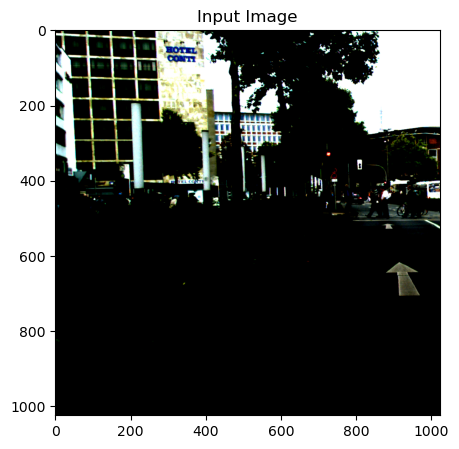

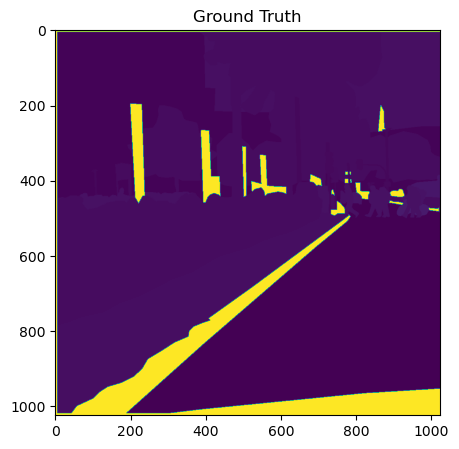

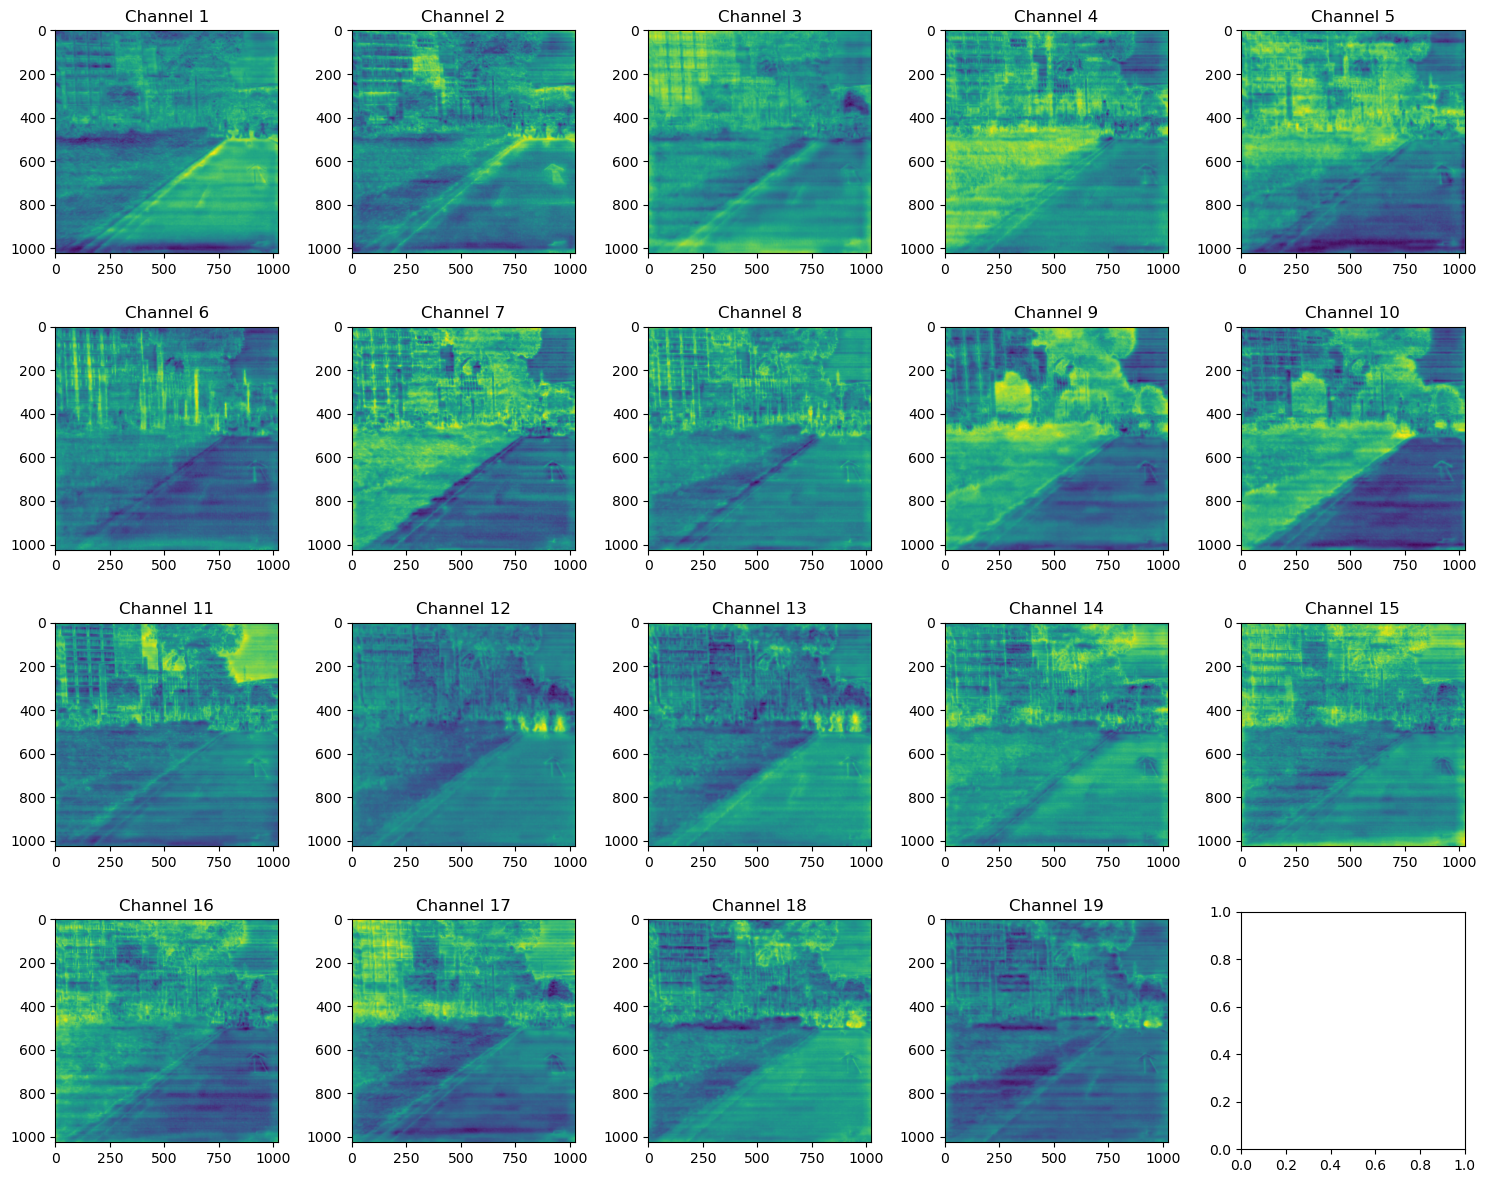

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1024, 1024])
2 torch.Size([]) torch.Size([1, 19, 1024, 1024])


In [11]:
import matplotlib.pyplot as plt

def plot_output(img, gt, out):
    # Plot the input image (RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
    plt.title('Input Image')
    plt.show()

    # Plot the ground truth (GT)
    plt.figure(figsize=(5, 5))
    plt.imshow(gt[0].cpu().numpy(), cmap='viridis')
    plt.title('Ground Truth')
    plt.show()

    # Convert the output tensor to NumPy and plot the available output channels separately
    out = out[1].cpu().numpy()
    _, axes = plt.subplots(4, 5, figsize=(15, 12))

    # Loop through the 19 channels and plot them
    for i in range(19):
        row, col = divmod(i, 5)  # Calculate the row and column for each subplot
        ax = axes[row, col]  # Get the corresponding subplot
        channel_data = out[0, i, :, :]
        ax.imshow(channel_data, cmap='viridis')  # You can change the colormap as needed
        ax.set_title(f'Channel {i + 1}')  # Set a title for the subplot
    plt.tight_layout()
    plt.show()


model.eval()
with torch.no_grad():
    for idx, sample in enumerate(test_loader):
        imgs = sample['image']      #B, 3, 1024, 2048
        gts = sample['label']       #B, 1024, 2048
        imgs = imgs.to(f'cuda:{model.device_ids[0]}', non_blocking=True)
        gts = gts.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

        img = imgs[:, :, :, :1024]
        gt = gts[:, :, :1024]
        out = model(img, gt)

        plot_output(img, gt, out)

        print(img.shape, gt.shape)
        print(len(out), out[0].shape, out[1].shape)
        break

# tokenization:  torch.Size([1, 65536, 64])
# tokenization:  torch.Size([1, 16384, 128])
# tokenization:  torch.Size([1, 4096, 320])
# tokenization:  torch.Size([1, 1024, 512])

In [12]:
mat = out[1].cpu().numpy()
mat = mat[0, 1, :, :]

# check the stat for values in mat 
print(mat.shape)
print(mat.min(), mat.max(), mat.mean(), mat.std())
print(np.unique(mat))


(1024, 1024)
-9.024251 2.7703276 -3.4717193 1.4890339
[-9.024251  -8.727279  -8.6975765 ...  2.7478664  2.7595606  2.7703276]
